# ROC AUC 

In [1]:
from classification import dao
from data import dao as data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.size"] = 14
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [4]:
from __private import fs

In [5]:
%%time
alcohol_classifier = dao.ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

firstperson_classifier = dao.ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

firstpersonlevel_classifier = dao.ClassifierAccess.get_byfile(
    "first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression"
)

CPU times: user 940 ms, sys: 398 ms, total: 1.34 s
Wall time: 27.6 s


In [13]:
firstpersonlevel_classifier.get_params()

{'clf': LogisticRegression(C=139.67415702201885, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
           solver='liblinear', tol=0.000449897709599141, verbose=0,
           warm_start=None),
 'clf__C': 139.67415702201885,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__max_iter': 100,
 'clf__multi_class': 'ovr',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'liblinear',
 'clf__tol': 0.000449897709599141,
 'clf__verbose': 0,
 'clf__warm_start': None,
 'features': FeatureUnion(n_jobs=1,
        transformer_list=[('text', Pipeline(steps=[('getter', ItemGetter(key='text')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

class2name= ["causal", "looking", "reflecting"]

def roc(clf, X_train, y_train, X_test, y_test):

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_test = label_binarize(np.array(y_test), [0,1,2])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='{0} ROC (area = {1:0.2f})'
                                       ''.format(class2name[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('First Person Label ROC')
    plt.legend(loc="lower right")
    plt.savefig("/Users/JasonLiu/Desktop/plt_roc_fpl.png")
    plt.show()

In [7]:
def roc_single(clf, X_train, y_train, X_test, y_test, title):
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_test = np.array(y_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig("/Users/JasonLiu/Desktop/" + title + ".png")
    plt.show()

In [8]:
X = data.DataAccess.get_as_dataframe()
L = data.LabelGetter(X)

# Producing Plots

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import (
    recall_score, precision_score, 
    accuracy_score, confusion_matrix,
    classification_report)

#### First Person Levels

In [24]:
XX, y = L.get_first_person_label()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=9
)

In [25]:
y.value_counts()

0    3287
1    1676
2    1394
dtype: int64

In [26]:
clf = firstpersonlevel_classifier

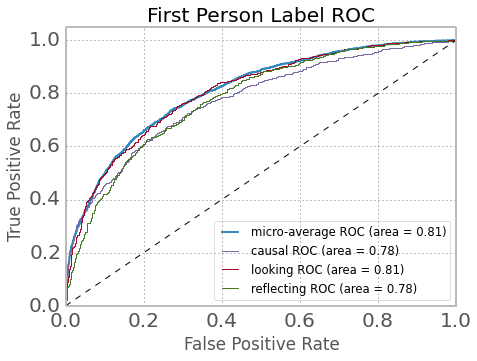

In [27]:
plt.rcParams["legend.fontsize"] = "small"
roc(clf, X_train, y_train, X_test, y_test)

In [28]:
# causal, looking, reflecting
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.70      0.74      0.72      1064
          1       0.62      0.57      0.60       600
          2       0.50      0.47      0.49       434

avg / total       0.63      0.64      0.64      2098



#### First Person

What is good is that recall is 89 so we only lose 10% of the first person tweets when we go to first person

In [17]:
plt.rcParams["legend.fontsize"] = "x-large"

In [18]:
XX, y = L.get_first_person()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=42
)

In [19]:
y.value_counts()

1    6357
0    3459
dtype: int64

In [16]:
clf = firstperson_classifier

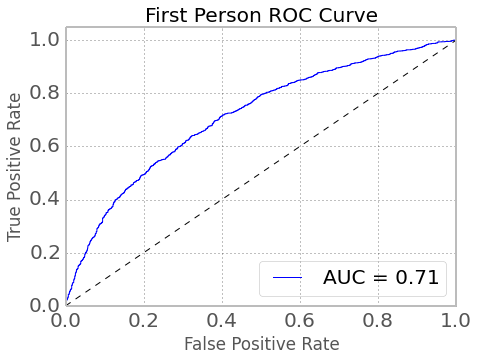

In [17]:
ax = roc_single(clf, X_train, y_train, X_test, y_test, title="First Person ROC Curve")
plt.savefig("/Users/JasonLiu/Desktop/plt_roc_fp.png")

In [18]:
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.64      0.23      0.33      1162
          1       0.68      0.93      0.79      2078

avg / total       0.67      0.68      0.62      3240



#### Alcohol 

In [20]:
XX, y = L.get_alcohol()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=42
)

clf = alcohol_classifier

In [21]:
y.value_counts()

1    10295
0     5355
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


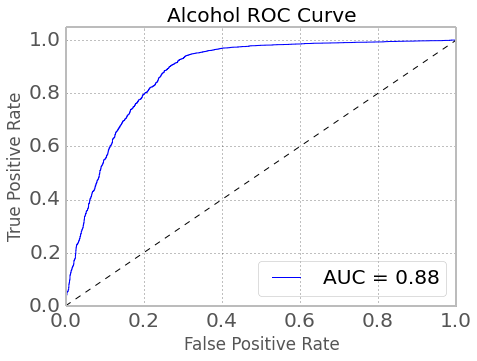

In [20]:
roc_single(clf, X_train, y_train, X_test, y_test, title="Alcohol ROC Curve")
plt.savefig("/Users/JasonLiu/Desktop/plt_roc_alch.png")

In [21]:
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.76      0.75      0.76      1802
          1       0.87      0.88      0.87      3363

avg / total       0.83      0.83      0.83      5165

